# Current-weather data GFS global analysis

## Load in wind data, and compute global fields of: 
#### streamfunction psi, velocity potential chi, Vdiv, Vrot, div, relvor, absvor

### Compute something interesting, like KE budget, etc.

#### First install miniconda (web-search it). 

#### Then, set up and enter an environment with these key packages:
`conda create -name ATM651 -c conda-forge xarray netcdf4 windspharm jupyterlab`
or use your "base" environment 
`conda install -c conda-forge xarray netcdf4 windspharm jupyterlab`

pro tip: mamba is faster than conda, a workalike

Or, you could run this code in Google Colab, using tactics [in this notebook](https://colab.research.google.com/drive/1cwVWzP4F_iynK9TjNJCy0GmB1VO-lbWm?usp=sharing)

In [214]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
from datetime import datetime, timedelta
import windspharm  ## <-- Spherical Harmonics package for the winds, spiffy
import windspharm.xarray as windspharmx

# Unidata current weather grids 

In [5]:
# https://thredds.ucar.edu/thredds/catalog/catalog.html
# ds means "dataset"
# Best time series is analyses up to present, then forecasts into future
# One challenge is that different fields have different names for time dimension
# (because GRIB was designed as a message format not a file format)

ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/Best' )
ds

<xarray.Dataset>
Dimensions:                                                                     (
                                                                                 lat: 181,
                                                                                 lon: 360,
                                                                                 time: 373,
                                                                                 time1: 372,
                                                                                 time2: 372,
                                                                                 ...
                                                                                 depth_below_surface_layer_bounds_1: 2,
                                                                                 height_above_ground_layer_bounds_1: 2,
                                                                                 height_above_ground_layer1_bounds_1: 2,
                                                                                 pressure_difference_layer1_bounds_1: 2,
                                                                                 pressure_difference_layer2_bounds_1: 2,
                                                                                 sigma_layer_bounds_1: 2)
Coordinates: (12/31)
  * lat                                                                         (lat) float32 ...
  * lon                                                                         (lon) float32 ...
  * time                                                                        (time) datetime64[ns] ...
    reftime                                                                     (time) datetime64[ns] ...
  * time1                                                                       (time1) datetime64[ns] ...
    reftime1                                                                    (time1) datetime64[ns] ...
    ...                                                                          ...
  * isobaric1                                                                   (isobaric1) float32 ...
  * height_above_ground4                                                        (height_above_ground4) float32 ...
  * height_above_ground5                                                        (height_above_ground5) float32 ...
  * sigma                                                                       (sigma) float32 ...
  * hybrid                                                                      (hybrid) float32 ...
  * hybrid1                                                                     (hybrid1) float32 ...
Dimensions without coordinates: time2_bounds_1, time3_bounds_1,
                                pressure_difference_layer_bounds_1,
                                depth_below_surface_layer_bounds_1,
                                height_above_ground_layer_bounds_1,
                                height_above_ground_layer1_bounds_1,
                                pressure_difference_layer1_bounds_1,
                                pressure_difference_layer2_bounds_1,
                                sigma_layer_bounds_1
Data variables: (12/180)
    LatLon_Projection                                                           int32 ...
    time2_bounds                                                                (time2, time2_bounds_1) datetime64[ns] ...
    time3_bounds                                                                (time3, time3_bounds_1) datetime64[ns] ...
    pressure_difference_layer_bounds                                            (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 ...
    depth_below_surface_layer_bounds                                            (depth_below_surface_layer, depth_below_surface_layer_bounds_1) float32 ...
    height_above_ground_layer_bounds                                            (

## To facilitate global integrals, add dMass and dArea fields

In [172]:
# Add new 'dMass' and 'dLon' and 'dArea' data arrays to the dataset for 
# making vertical mean, zonal mean, area mean 

ds['dMass'] = ( ds.isobaric.diff(dim='isobaric') / 9.81 ).assign_attrs(units='kg/m^2')  
ds['dLon'] = ( ds.lon.diff(dim='lon') ).assign_attrs(units='degrees')       

# dp/g is kg/m2 units

# m2, from square degrees, based on 10000 km eq-pole distance (111111 m/deg)
# CAREFUL! dlat is negative
ds['dArea'] =-(ds.lat.diff(dim='lat') * 111111.1 *\
               ds.lon.diff(dim='lon') * 111111.1 *np.cos(ds.lat *np.pi/180.) \
               ).assign_attrs(units='m^2')

# ds.dArea.plot()

## Extract 3D winds at a time level or slice 

In [225]:
met   = ds[ ['u-component_of_wind_isobaric','v-component_of_wind_isobaric', \
             'Vertical_velocity_pressure_isobaric','Geopotential_height_isobaric',\
             'Absolute_vorticity_isobaric'] ]

one_hour = timedelta(hours=1) 
timeslice = slice(datetime.now()-1.5*one_hour,datetime.now()+1.5*one_hour)
met_now    = met.sel( time= timeslice ).squeeze()

met_now

<xarray.Dataset>
Dimensions:                              (isobaric: 41, lat: 181, lon: 360)
Coordinates:
  * lat                                  (lat) float32 90.0 89.0 ... -89.0 -90.0
  * lon                                  (lon) float32 0.0 1.0 ... 358.0 359.0
    time                                 datetime64[ns] 2023-11-12T15:00:00
  * isobaric                             (isobaric) float32 1.0 2.0 ... 1e+05
    reftime                              datetime64[ns] ...
Data variables:
    u-component_of_wind_isobaric         (isobaric, lat, lon) float32 ...
    v-component_of_wind_isobaric         (isobaric, lat, lon) float32 ...
    Vertical_velocity_pressure_isobaric  (isobaric, lat, lon) float32 ...
    Geopotential_height_isobaric         (isobaric, lat, lon) float32 ...
    Absolute_vorticity_isobaric          (isobaric, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

# Spherical harmonics package from global u and v fields 

In [226]:
V = windspharm.xarray.VectorWind(met_now['u-component_of_wind_isobaric'],\
                                 met_now['v-component_of_wind_isobaric'])

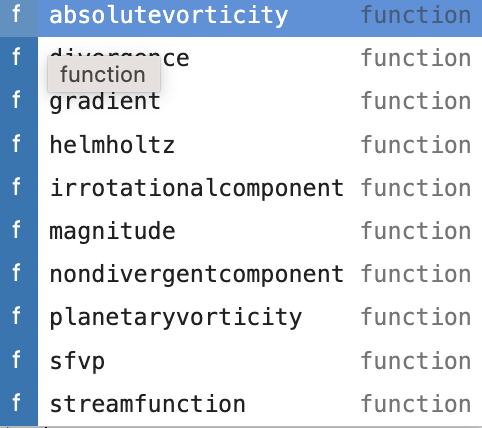
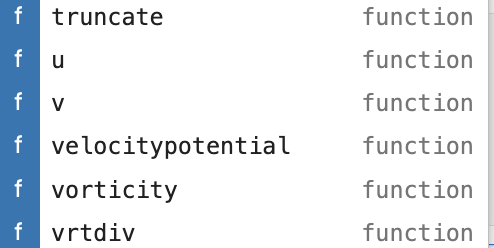

In [233]:
Vrot = V.nondivergentcomponent()
Vdiv = V.irrotationalcomponent()
absvor = V.absolutevorticity()
vrt, div = V.vrtdiv()
psi = V.streamfunction()
chi = V.velocitypotential()
u = V.u()
v = V.v()
Z = met_now.Geopotential_height_isobaric

# Streamfunction: a lot like (geopotential height/f)
### at least where winds are nearly geostrophic, mostly rotational 

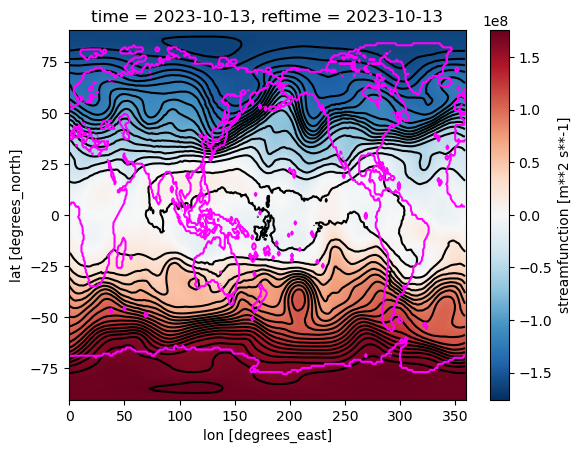

In [298]:
psi.sel(isobaric=20000).plot()
Z.sel(isobaric=20000).plot.contour(levels=20, colors='black') ; 
ds.Geopotential_height_surface[0].plot.contour(colors='magenta', levels=[0.1] )

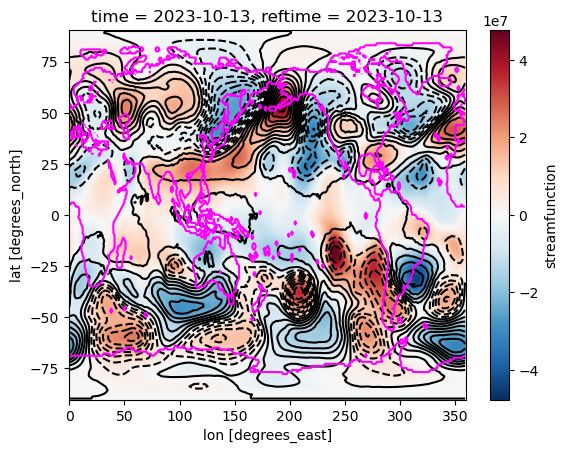

In [299]:
# Eddy: deviations from the zonal mean

eddypsi = psi - psi.mean(dim='lon')
eddyZ = Z - Z.mean(dim='lon')

eddypsi.sel(isobaric=20000).plot()
eddyZ.sel(isobaric=20000).plot.contour(levels=20, colors='black')
plt.title('Eddy psi (colors) and Z (contours)')
ds.Geopotential_height_surface[0].plot.contour(colors='magenta', levels=[0.1] )

In [314]:
# Augment the met_now dataset (one time level) and write it out 

met_now['urot'] = Vrot[0]
met_now['vrot'] = Vrot[1]
met_now['udiv'] = Vdiv[0]
met_now['vdiv'] = Vdiv[1]
met_now['psi'] = psi
met_now['eddypsi'] = eddypsi
met_now['eddyZ'] = eddyZ
met_now['chi'] = chi
met_now['vrt'] = vrt
met_now['div'] = div
met_now.to_netcdf('~/Met_Now_Spherical.nc') # in home directory
met_now

<xarray.Dataset>
Dimensions:                              (isobaric: 41, lat: 181, lon: 360)
Coordinates:
  * lat                                  (lat) float32 90.0 89.0 ... -89.0 -90.0
  * lon                                  (lon) float32 0.0 1.0 ... 358.0 359.0
    time                                 datetime64[ns] 2023-11-12T15:00:00
  * isobaric                             (isobaric) float32 1.0 2.0 ... 1e+05
    reftime                              datetime64[ns] 2023-11-12T12:00:00
Data variables: (12/15)
    u-component_of_wind_isobaric         (isobaric, lat, lon) float32 ...
    v-component_of_wind_isobaric         (isobaric, lat, lon) float32 ...
    Vertical_velocity_pressure_isobaric  (isobaric, lat, lon) float32 ...
    Geopotential_height_isobaric         (isobaric, lat, lon) float32 7.542e+...
    Absolute_vorticity_isobaric          (isobaric, lat, lon) float32 ...
    urot                                 (isobaric, lat, lon) float32 -10.53 ...
    ...                                   ...
    psi                                  (isobaric, lat, lon) float32 -1.97e+...
    eddypsi                              (isobaric, lat, lon) float32 -480.0 ...
    eddyZ                                (isobaric, lat, lon) float32 0.00781...
    chi                                  (isobaric, lat, lon) float32 1.037e+...
    vrt                                  (isobaric, lat, lon) float32 5.738e-...
    div                                  (isobaric, lat, lon) float32 -6.487e...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

# Velocity potential: spotlights the divergent winds 

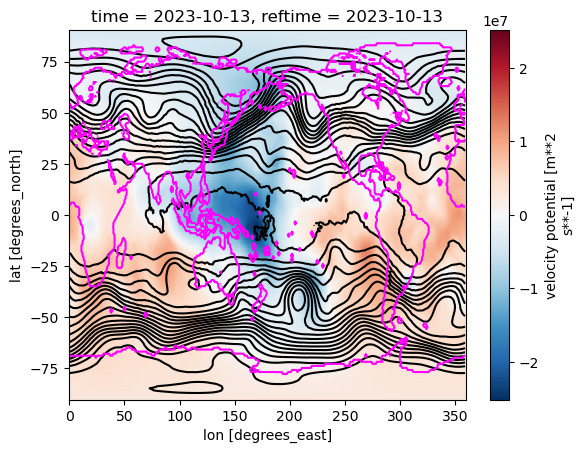

In [300]:
chi.sel(isobaric=20000).plot()
Z.sel(isobaric=20000).plot.contour(levels=20, colors='black')
ds.Geopotential_height_surface[0].plot.contour(colors='magenta', levels=[0.1] )

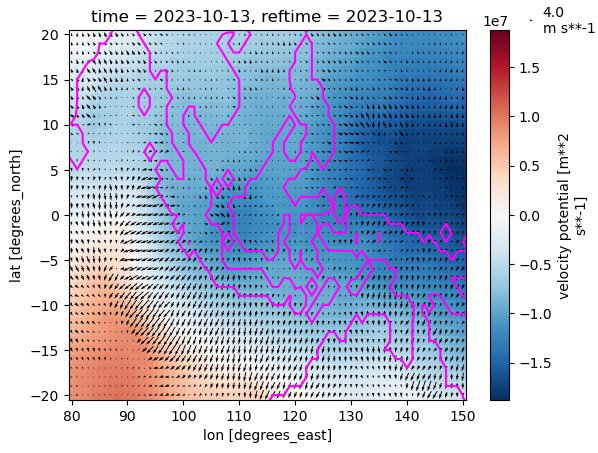

In [307]:
# Clarify that with a zoom-in
divwnd = xr.merge([Vdiv[0],Vdiv[1]])

chi.sel(   isobaric=20000,lat=slice(20,-20),lon=slice(80,150)).plot()

divwnd.sel(isobaric=20000,lat=slice(20,-20),lon=slice(80,150)).plot.\
        quiver(x="lon", y="lat", u="u_chi", v="v_chi")

ds.Geopotential_height_surface[0].plot.contour(colors='magenta', levels=[0.1] )

--------------
# Assignment ideas: (any one is enough, just one diamond of learning per person) 

### 0. Display and explore the fields computed above in the IDV. To do that, [download and install](https://downloads.unidata.ucar.edu/idv/) IDV. Launch it. In the Dashboard, Data Choosers tab, General>Files in the left hand gutter, find ~Met_Now_Spherical.nc (in your home directory), as written above in this notebook. File->Open Spherical_currentweather.xidv from [this notebook's directory](), and Change Data Paths in its opening dialog to point to your Met_Now_Spherical.nc datafile. 

#### 0a. How do psi and Z differ? View their total and eddy components. 

**Hint**: rotational flows at low latitudes have just as strong a psi gradient as at higher latitudes, but Z is much flatter in the tropics than midlatitudes. Z/f is roughly the streamfunction for geostrophic wind, which is a good approximation to total wind. Understand, explain to the class. 

### 1. Compute the KE of rotational and divergent components of the total wind field. Do these add up to the total KE (as seen in the KEbudget_currenteather notebook)? Why should it? If so, plug V = (Vrot + Vdiv) into the KE budget (V dot dV/dt) and express in math the *orthogonality* condition of this Helmholtz decomposition. 

### 2. Explore the Wallace-Hobbs question of "why cyclones are more intense than anticyclones". 

#### 2a. What does this statement mean actually? Does it mean the *vorticity* PDF is asymmetric? Or the *eddy streamfucntion* PDF? The Z or eddyZ PDF? Notice that, of course, you may have to make histograms only for one hemisphere, as cyclonic vorticity has different signs in SH and NH. 

#### 2b. Is it also true at upper levels (where storms are divergent), or only at low levels (where one might invoke moisture-enhanced convergence in upward motion storms as the cause)? 

**Hint**: What happens if a fluctuating random divergence field D (equally likely to be convergent or divergent) is applied to the ODE-like Lagrangian version of the vorticity equation: 

$$ d/dt(\zeta_{abs}) = -\zeta_{abs} \times D $$ 

whose solution is 

$$ \zeta_{abs}(t) = \zeta_{abs_0} \times e^{-Dt} $$

? 

Notice that the exponential is unbounded for its positive growth when D<0, but relaxes to 0 for D>0. 


...

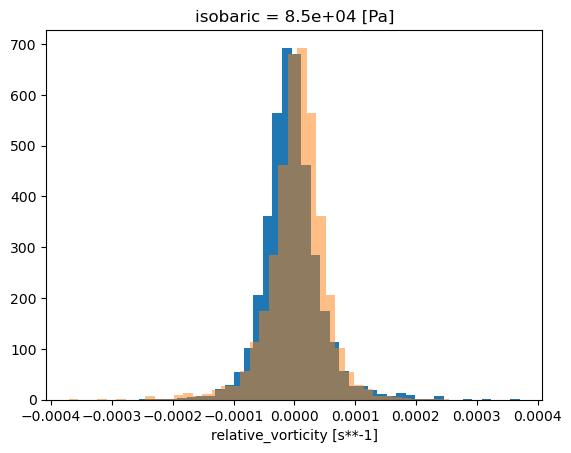

In [295]:
# One way to see asymmetry in the PDF of vorticity in NH 35-45 lat: 
# plot the reversed one on top, semi-transparent (alpha=0.5) 

vrt.sel(lat=slice(45,35), isobaric=85000).plot.hist(bins=40) ;
(-vrt).sel(lat=slice(45,35), isobaric=85000).plot.hist(bins=40, alpha=0.5) ;

Text(0.5, 1.0, 'eddy streamfunction and Z, 50-60N and 20-30N')

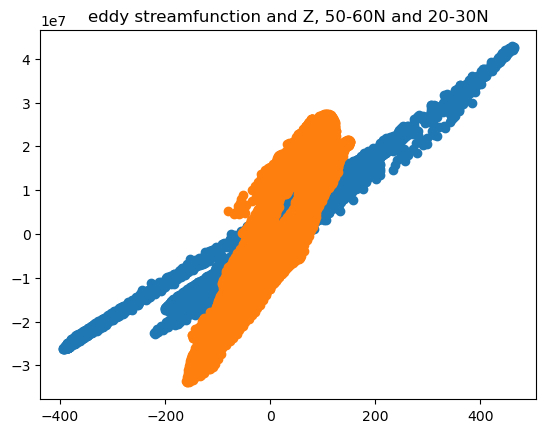

In [333]:
# Riddle me this: how is eddy streamfunction different from eddy Z?
# Hint: Z/f is the streamfunction for geostrophic wind, which is a decent approximation to true wind

plt.scatter(eddyZ.sel(lat=slice(60,50), isobaric=20000), \
            eddypsi.sel(lat=slice(60,50), isobaric=20000) ) #blue is first 

plt.scatter(eddyZ.sel(lat=slice(30,20), isobaric=20000), \
            eddypsi.sel(lat=slice(30,20), isobaric=20000) ) ; #orange is second

plt.title('eddy streamfunction and Z, 50-60N and 20-30N')